# The Effect of Languages on Movies: The Multi-Faceted Story of a Single Parameter

## Data Preprocessing Pipeline
- Clean up the prefix and suffix of some columns
- Overview of data information, e.g. data type, missing data
- Combine Mojo dataset with the original data to improve the situation with a lot of missing revenue data

In [1]:
import numpy as np
import pandas as pd
import re
import ast
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Change the file path for the file movie.metadata.tsv
file_path = "data/movie.metadata.tsv"

In [3]:
# Reading the file into a pandas dataframe
movie_summaries = pd.read_csv(file_path, sep="\t", header=None)
movie_summaries.columns = ["Wikipedia movie ID",
 "Freebase_movie_ID",
 "Movie_name",
 "Movie_release_date",
 "Movie_box_office_revenue",
 "Movie_runtime",
 "Movie_languages",
 "Movie_countries",
 "Movie_genres"]
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Remove prefix '/m/'
movie_summaries['Freebase_movie_ID'] = movie_summaries['Freebase_movie_ID'].str.replace('/m/', '')

In [5]:
# Create new columns for languages, countries and genres
# The data type of the new columns is list containing all possible values
# Only take the values into account for now,
# If we need the code for further analysis, just apply x.keys() instead of x.values()

movie_summaries['Movie_languages_clean'] = movie_summaries['Movie_languages'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_countries_clean'] = movie_summaries['Movie_countries'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_genres_clean'] = movie_summaries['Movie_genres'].apply(ast.literal_eval).apply(lambda x: list(x.values()))

In [6]:
# Extract the release year
# This column only contains the years
movie_summaries['Movie_release_year'] = movie_summaries['Movie_release_date'].str.extract(r'(\d{4})')

# Convert strings to datetime values if there are
# For the rows with only years, the value is replaced by NaT
# pd.to_datetime has a bug if the format provided is more "precise" than what is in the dataframe, it has default values and will not
# raise an error or replace with NaT
# specifically %Y-%m-%d with year 2000 defaults to 2000-01-01, even with the exact=True argument.
movie_summaries['Movie_release_date_datetime'] = movie_summaries['Movie_release_date'].astype('str').apply(
        lambda x: pd.to_datetime(x if "-" in x else pd.NaT, errors="coerce")
)

In [7]:
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT


In [8]:
# Add mojo box office dataset
import requests
from bs4 import BeautifulSoup

In [9]:
def getData(year):
    url = f'https://www.boxofficemojo.com/year/{year}/?sortDir=asc&sort=rank&grossesOption=totalGrosses'

    # Send a GET request to the URL
    response = requests.get(url)

    df = pd.DataFrame()
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract relevant information (modify this based on the structure of the webpage)
        # Example: Extracting movie titles
        df['movie_title'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-left mojo-field-type-release mojo-cell-wide')]
        df['movie_revenue'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-right mojo-field-type-money mojo-estimatable')]


    return df

In [10]:
# Uncomment if you need to re-write the data from the website

# df_all = pd.DataFrame()

# # Python range is not inclusive for the second value
# for i in range(1977, 2024):
#    temp = getData(i)
#    df_all = pd.concat([df_all, temp], ignore_index=True)

# # Write to csv
# df_all.to_csv('mojo_data.csv', header=None, index=False)

In [11]:
# Reading the file into a pandas dataframe
df_all = pd.read_csv('mojo_data.csv', header=None)
df_all.columns = ["movie_title",
 "movie_revenue"]
df_all.head()

,movie_title,movie_revenue
0,Star Wars: Episode IV - A New Hope,"$307,263,857"
1,Smokey and the Bandit,"$126,737,428"
2,Close Encounters of the Third Kind,"$116,395,460"
3,Saturday Night Fever,"$94,213,184"
4,A Bridge Too Far,"$50,750,000"


In [12]:
# We can just always consider the original dataset, and replace the missing revenues with the ones from the Mojo dateset

# Drop duplicate movies, based on name only
df_all = df_all.drop_duplicates(subset=['movie_title'])
movie_summaries = movie_summaries.drop_duplicates(subset=['Movie_name'])
# Merge dataframes based on the movie name, left join so we keep all of the original data
merged_df = pd.merge(movie_summaries, df_all, right_on='movie_title', left_on='Movie_name', how='left')

# Drop the extra column (either 'movie_title' or 'Movie_name') if needed
# merged_df = merged_df.drop('movie_title', axis=1)

# Cleaning up the revenues

# Remove the dollar sign and commas
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(str).str.replace('$', '').str.replace(',', '')

# Convert the column to floats
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(float)

# Create a boolean mask for rows where movie_revenue is NaN and gross_revenue is not NaN
mask = (pd.isna(merged_df['Movie_box_office_revenue'])) & (~pd.isna(merged_df['movie_revenue']))

# Replace missing values in Movie_box_office_revenue with movie_revenue
merged_df.loc[mask, 'Movie_box_office_revenue'] = merged_df.loc[mask, 'movie_revenue']

## Q1: Does language variety mean more box office revenue?
The purpose of this section is to investigate the possible correlation between the box office revenue and the number of languages presented in a movie. First, we determine the length of the language list, assigning a value of zero if the list is empty. In addition, we eliminate all NaN values, especially given our initial investigation which revealed a considerable amount of missing data in the movie revenue. At the end, we have in total 8401 useful entries to analyse.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Count the number of languages in a movie
# Create a new column
df = merged_df.copy(deep=True)
df.info()
df['language_count'] = df['Movie_languages_clean'].apply(len)
df_language_count = df[['Movie_name', 'Movie_box_office_revenue', 'language_count']].dropna()
df_language_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75478 entries, 0 to 75477
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Wikipedia movie ID           75478 non-null  int64         
 1   Freebase_movie_ID            75478 non-null  object        
 2   Movie_name                   75478 non-null  object        
 3   Movie_release_date           68978 non-null  object        
 4   Movie_box_office_revenue     9376 non-null   float64       
 5   Movie_runtime                56345 non-null  float64       
 6   Movie_languages              75478 non-null  object        
 7   Movie_countries              75478 non-null  object        
 8   Movie_genres                 75478 non-null  object        
 9   Movie_languages_clean        75478 non-null  object        
 10  Movie_countries_clean        75478 non-null  object        
 11  Movie_genres_clean           75478 non-nu

#### Language Count Distribution
We focus on the number of languages and try to understand the distribution of languages. The plot shows that the majority of films (76.56% of non-NaN data in box office revenue) have only one language. This presents a challenge for further analysis as it indicates a significant imbalance in the data set when examining language diversity.

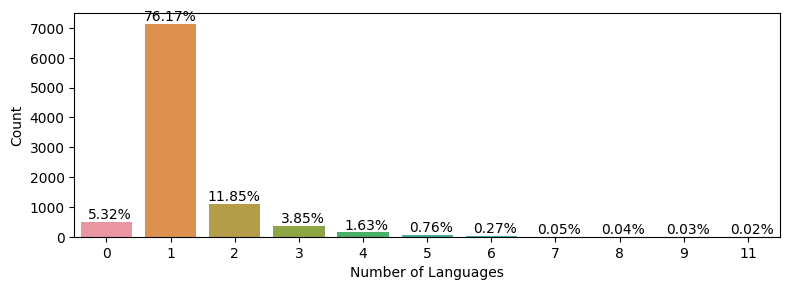

In [15]:
plt.figure(figsize=(8,3))
ax = sns.countplot(df_language_count, x='language_count')
ax.set(xlabel='Number of Languages', ylabel='Count')
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/float(len(df_language_count)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right', va='bottom')

plt.tight_layout()

#### Box Office Revenue Distribution
The box office revenue data have some extreme values. To improve the clarity and interpretability of the distribution in our visualizations, we use a logarithmic scale.

Text(0.5, 0, 'Box Office Revenue\n(Log Scale)')

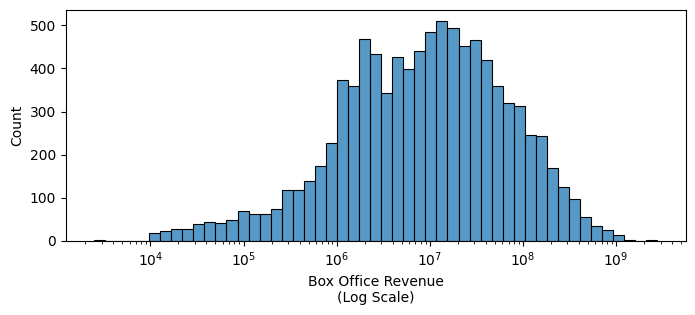

In [16]:
plt.figure(figsize=(8,3))
sns.histplot(df_language_count, x='Movie_box_office_revenue', log_scale=True)
plt.xlabel('Box Office Revenue\n(Log Scale)')

#### Box Office Revenue v.s. Number of Languages
We want to examine the correlation between these two variables. While this visualization suggests a trend towards higher box office results for more languages, it is important to note that the comparison may not be meaningful due to unequal data sizes across language groups.

In [19]:
# plt.figure(figsize=(8, 4))
# sns.boxplot(df_language_count, y='Movie_box_office_revenue', x='language_count', fill=False, width=.5, linewidth=.75, showfliers=False)
# sns.stripplot(df_language_count, y='Movie_box_office_revenue', x='language_count', size=1.5, log_scale=True, color='grey', alpha=0.5)
# plt.xlabel('Number of Languages')
# plt.ylabel('Box Office Revenue\n(Log Scale)')

### Correlation and Test
So, for the correlation, we formulate the following hypothesis test:
- **Null Hypothesis (H0):** There is no correlation between the number of languages and box revenue.
- **Alternative Hypothesis (H1):** There is a correlation between the number of languages and box revenue.

We select a significance level of 0.05. The calculation of the correlation coefficient and the associated p-value provides further information on the relationship between box office receipts and the number of languages. The calculated p-value is smaller than the selected significance level, so that we can reject the null hypothesis. This indicates a statistically significant correlation between the number of languages and box office takings. However, given the unbalanced data set, further tests or data transformations should be performed to confirm this result.

In [20]:
from scipy.stats import pearsonr

correlation_coefficient, p_value = pearsonr(df_language_count['language_count'], df_language_count['Movie_box_office_revenue'])
print(f"R: {correlation_coefficient}\nP-value: {p_value}")

R: 0.1568608770490559
P-value: 1.0163805236737187e-52


## Q2: Which languages lead to more box office revenue?


### Total revenue per language

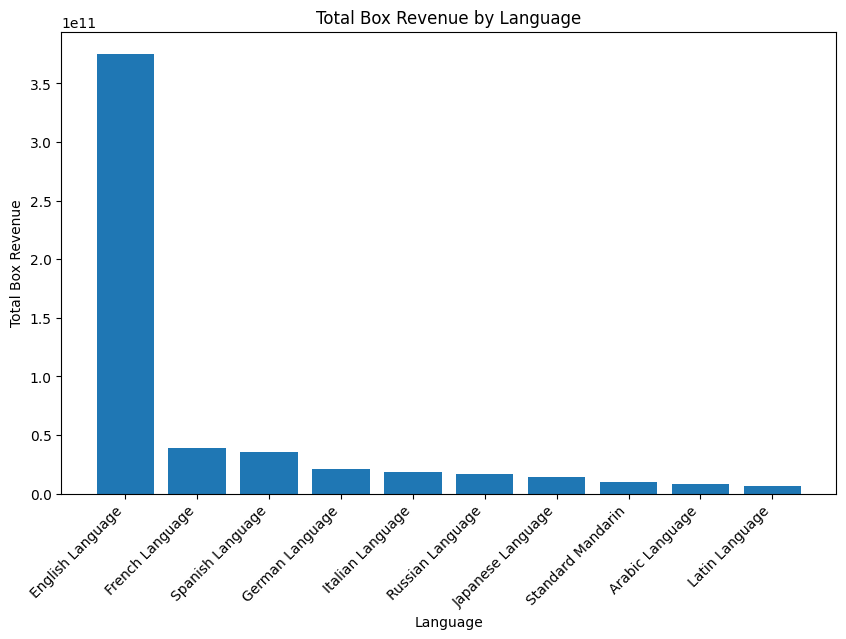

The language that makes the most money is English Language with a total revenue of $375,440,702,275.0


In [68]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')
language_revenue = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].sum().reset_index()
language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_revenue['Movie_languages_clean'][:10], language_revenue['Movie_box_office_revenue'][:10])
plt.xlabel('Language')
plt.ylabel('Total Box Revenue')
plt.title('Total Box Revenue by Language')
plt.xticks(rotation=45, ha='right')

plt.show()
language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)
top_language = language_revenue.iloc[0]['Movie_languages_clean']
top_revenue = language_revenue.iloc[0]['Movie_box_office_revenue']
print(f"The language that makes the most money is {top_language} with a total revenue of ${top_revenue:,}")

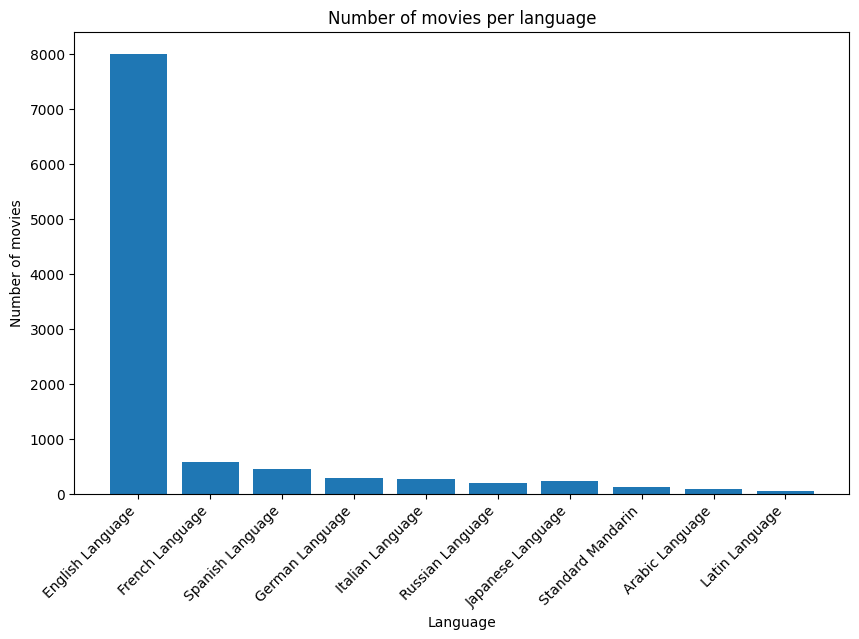

In [70]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')
language_revenue = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count']).reset_index()
language_revenue = language_revenue.sort_values(by='sum', ascending=False)

# Calculate the average revenue per movie for each language
language_stats = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count'])
language_stats['average_revenue_per_movie'] = language_stats['sum'] / language_stats['count']
language_stats = language_stats.sort_values(by='average_revenue_per_movie', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_revenue['Movie_languages_clean'][:10], language_revenue['count'][:10])
plt.xlabel('Language')
plt.ylabel('Number of movies')
plt.title('Number of movies per language')
plt.xticks(rotation=45, ha='right')

plt.show()


## Average revenue per language

The language with the highest average revenue per movie is Old English language with an average revenue of $747,456,792.33


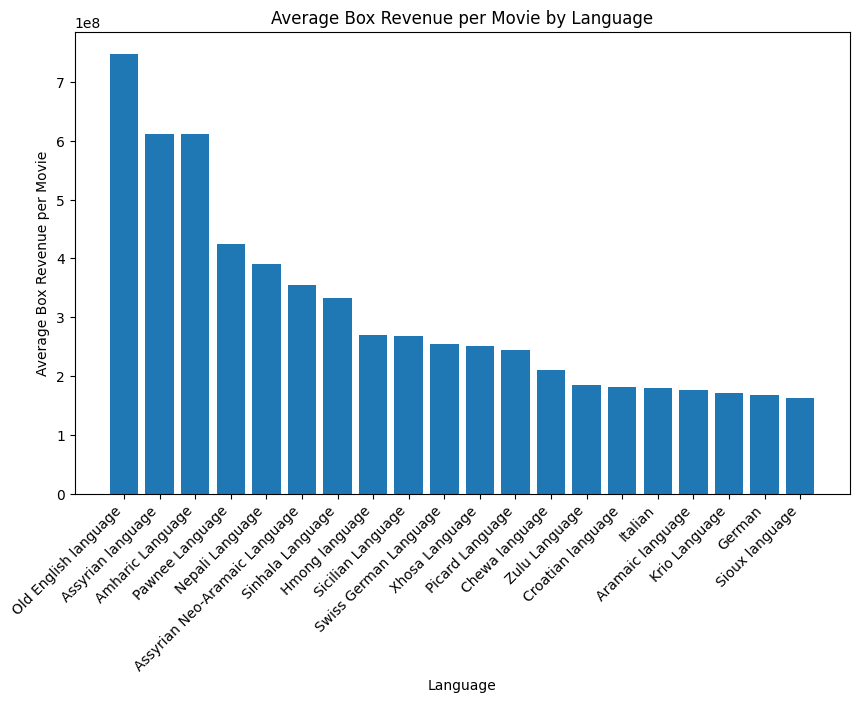

In [62]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')

# Calculate the average revenue per movie for each language
language_stats = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count'])
language_stats['average_revenue_per_movie'] = language_stats['sum'] / language_stats['count']
language_stats = language_stats.sort_values(by='average_revenue_per_movie', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_stats.index[:20], language_stats['average_revenue_per_movie'][:20])
plt.xlabel('Language')
plt.ylabel('Average Box Revenue per Movie')
plt.title('Average Box Revenue per Movie by Language')
plt.xticks(rotation=45, ha='right')


top_language = language_stats.index[0]
top_average_revenue = language_stats['average_revenue_per_movie'].iloc[0]
print(f"The language with the highest average revenue per movie is {top_language} with an average revenue of ${top_average_revenue:,.2f}")


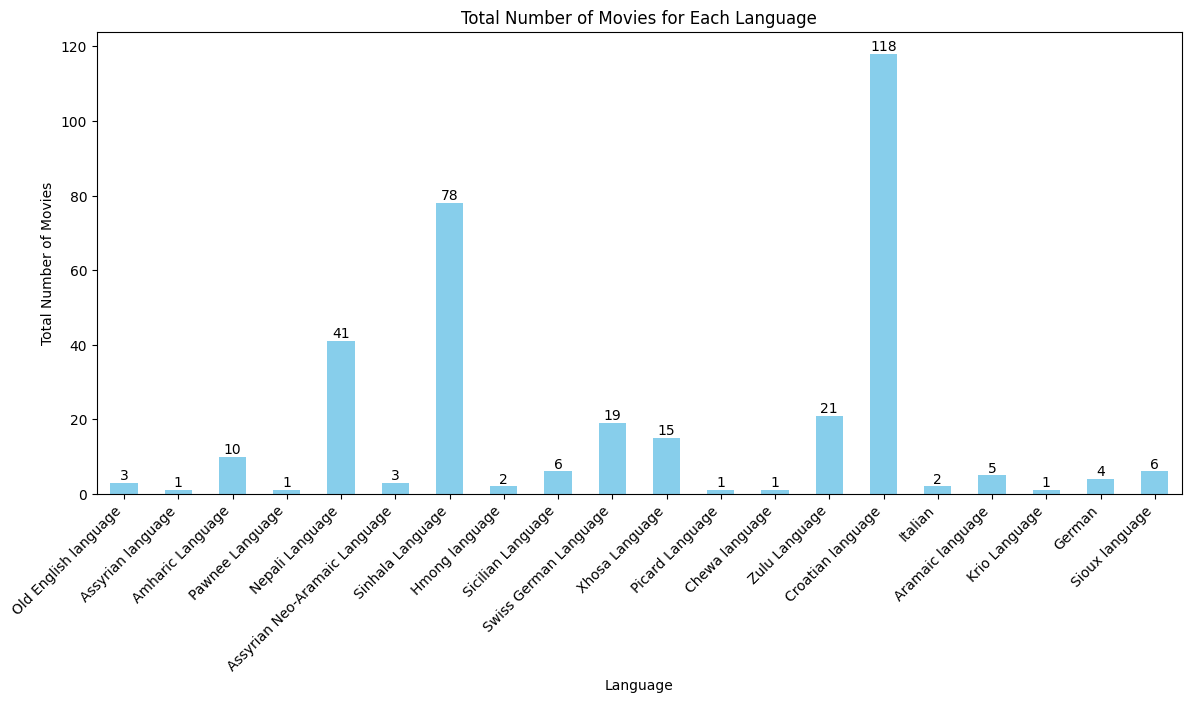

In [63]:
total_movies_per_language = df_language['Movie_languages_clean'].value_counts()

# Languages with the highest revenues
specified_order = ['Old English language', 'Assyrian language', 'Amharic Language',
                   'Pawnee Language', 'Nepali Language', 'Assyrian Neo-Aramaic Language',
                   'Sinhala Language', 'Hmong language', 'Sicilian Language',
                   'Swiss German Language', 'Xhosa Language', 'Picard Language',
                   'Chewa language', 'Zulu Language', 'Croatian language', 'Italian',
                   'Aramaic language', 'Krio Language', 'German', 'Sioux language']

total_movies_per_language = total_movies_per_language.reindex(specified_order, fill_value=0)

# Plotting the bar chart
plt.figure(figsize=(14, 6))
bars = total_movies_per_language.plot(kind='bar', color='skyblue')
plt.title('Total Number of Movies for Each Language')
plt.xlabel('Language')
plt.ylabel('Total Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adding text annotations on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', color='black')


plt.show()

A lot of exotic/less known languages have the highest average revenue.
This could be explained by the fact that exotic languages are only used rarely, in big budget movies, which brings the average revenue up, compared to more common languages that are used in a lot movies, including movies that have low box office revenue.

For example, we can look at the Old English language. The only movies containing these languages are very popular ones with high budgets.

In [ ]:
# Movies that used Old English
test = df_language.explode('Movie_languages_clean')
display(test.loc[test['Movie_languages_clean'] == 'Old English language'])

In [ ]:
import statsmodels.api as sm

df_reg = merged_df[['Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]

# Remove nans
df_reg = df_reg.dropna()
df_reg = df_reg.dropna(axis=1)

df_reg = df_reg.explode('Movie_languages_clean', ignore_index=True)
df_reg = df_reg.dropna(subset=['Movie_languages_clean'])

df_reg['Movie_languages_clean'] = df_reg['Movie_languages_clean'].apply(lambda x: x.encode('utf-8', 'replace').decode('utf-8'))

# The languages are transformed into columns representing 0 or 1 for whether the movie contains the language
df_reg = pd.get_dummies(df_reg, columns=['Movie_languages_clean'], prefix='', prefix_sep='')


# Perform linear regression
X = df_reg.drop(['Movie_name', 'Movie_box_office_revenue'], axis=1)  # Features = all languages
y = df_reg['Movie_box_office_revenue']  # y = revenue


# Add a constant to the features (required for statsmodels) since we're not using an explicit formula
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

print(model.summary())

In [ ]:
# Extracting coefficients, p-values, and feature names
coefficients = model.params
p_values = model.pvalues
features = model.params.index

# Creating a DataFrame
regression_summary = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients,
    'p_value': p_values
}).reset_index(drop=True)


# Select languages that have a high p-value from the logistic regression
high_sig = regression_summary.loc[regression_summary['p_value'] < 0.05]

# Sort the DataFrame by p-value in ascending order and select the first 3 rows
lowest_p_values = high_sig.sort_values('p_value').head(10)

# Display the result
display(lowest_p_values)

Our r-squared value is close to 0, indicating that the model does not explain almost any variability in the dependent variable.

Most of the languages with the lowest p-value are exotic, i.e. not very commonly usede. This is in line with our previous assumption that exotic languages are associated with high revenue because they are rarely used, and mainly in high-budget movies.

However, it is important to note that this is not sufficient to conclude that these languages have an impact on the revenue of a movie.

## Q4: Which languages are more present in a specific genre?

### Overall Language Distribution

In [ ]:
# Create a dictionary to count the number of movies for each language
language_count = {}

# Iterate through the 'movie_languages_clean' column and count occurrences of each language
for languages in movie_summaries['Movie_languages_clean']:
    for language in languages:
        if language in language_count:
            language_count[language] += 1
        else:
            language_count[language] = 1

In [ ]:
# Convert the dictionary to a pandas DataFrame for easy plotting
df_language_count = pd.DataFrame(list(language_count.items()), columns=['Language', 'Movie Count'])

# Sort the DataFrame by Movie Count for better visualization
df_language_count = df_language_count.sort_values(by='Movie Count', ascending=False)

# Number of top languages that will be shown in the plot
top_languages_count = 15  

# Select the top N languages
top_languages = df_language_count.head(top_languages_count)

# Create a new row for 'Others' and sum the counts
others_count = df_language_count.iloc[top_languages_count:]['Movie Count'].sum()
others_row = pd.DataFrame({'Language': ['Others'], 'Movie Count': [others_count]})

# Concatenate the top languages and 'Others'
df_language_combined = pd.concat([top_languages, others_row])

# Plotting a pie chart
plt.figure(figsize=(10, 10))
plt.pie(df_language_combined['Movie Count'], labels=df_language_combined['Language'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title(f'Distribution of Top {top_languages_count} Languages by Movie Count')
plt.show()

The dataset shows a significant dominance of movies in the English language. This is a common trend in global cinema, as English is a widely spoken and understood language. This dominance may indicate a bias toward English-language films in the dataset.

### Overall Genre Distribution

In [ ]:
# genre count
genres_count = {}

for genres in movie_summaries['Movie_genres_clean']:
    for genre in genres:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

In [ ]:
# Convert the dictionary to a pandas DataFrame for easy plotting
df_genres_count = pd.DataFrame(list(genres_count.items()), columns=['Genre', 'Movie Count'])

# Sort the DataFrame by Movie Count for better visualization
df_genres_count = df_genres_count.sort_values(by='Movie Count', ascending=False)

# Number of top languages that will be shown in the plot
top_genres_count = 20  

# Select the top N genres
top_genres = df_genres_count.head(top_genres_count)

# Create a new row for 'Others' and sum the counts
others_count_genres = df_genres_count.iloc[top_genres_count:]['Movie Count'].sum()
others_row_genres = pd.DataFrame({'Genre': ['Others'], 'Movie Count': [others_count_genres]})

# Concatenate the top genres and 'Others' for the pie chart
df_genres_combined = pd.concat([top_genres, others_row_genres])

# Plotting a pie chart
plt.figure(figsize=(15, 15))
plt.pie(df_genres_combined['Movie Count'], labels=df_genres_combined['Genre'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title(f'Distribution of Top {top_genres_count} Genres by Movie Count', fontsize=16)
plt.show()

Some genres clearly dominate the dataset. For instance, "Drama," "Comedy," "Thriller," and "Action" are among the most prevalent genres. This is to be expected as these genres are popular and widely produced. The dataset covers a broad range of genres, including more niche genres like "Space opera," "Film-Opera," "Ealing Comedies," and "B-movie."

### Genre distribution in the most popular languages

In [ ]:
# Set the Seaborn style
sns.set(style="whitegrid")

# Number of languages for which we will create separate pie charts for genres
top_languages_count_genres = 10  

top_languages_genre = df_language_count.head(top_languages_count)

# Number of genres to plot for each language
top_genres_per_language = 5  

# Initialize subplots dynamically based on the number of top languages
nrows = top_languages_count_genres // 2 + top_languages_count_genres % 2  # Adjust for odd counts
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, nrows * 7))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Initialize a list to store DataFrames for each language
dfs_genre_breakdown = []

# Iterate over the top languages
for i, language in enumerate(top_languages_genre['Language']):
    # Filter the DataFrame for the current language
    df_language = movie_summaries[movie_summaries['Movie_languages_clean'].apply(lambda x: language in x)]
    
    # Count the genres for the current language
    genres_count_language = {}
    for genres in df_language['Movie_genres_clean']:
        for genre in genres:
            if genre in genres_count_language:
                genres_count_language[genre] += 1
            else:
                genres_count_language[genre] = 1
    
    # Convert the dictionary to a pandas DataFrame
    df_genre_count_language = pd.DataFrame(list(genres_count_language.items()), columns=['Genre', 'Movie Count'])
    
    # Select the top genres and combine the rest into 'Others'
    top_genres = df_genre_count_language.nlargest(top_genres_per_language, 'Movie Count')
    others_count = df_genre_count_language['Movie Count'].sum() - top_genres['Movie Count'].sum()
    others_row = pd.DataFrame({'Genre': ['Others'], 'Movie Count': [others_count]})
    
    # Concatenate the top genres and 'Others'
    df_genre_count_language = pd.concat([top_genres, others_row])
    
    # Add the language information
    df_genre_count_language['Language'] = language
    
    # Calculate the percentage of each genre
    df_genre_count_language['Percentage'] = (df_genre_count_language['Movie Count'] / df_genre_count_language['Movie Count'].sum()) * 100
    
    # Append the DataFrame to the list
    dfs_genre_breakdown.append(df_genre_count_language)


    # Plotting pie charts for each language
    if i < top_languages_count_genres:
        ax = axes[i]
        ax.pie(df_genre_count_language['Percentage'], labels=df_genre_count_language['Genre'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Paired"))
        ax.set_title(f'Top {top_genres_per_language} Genres for {language} Movies')



# Hide empty subplots
for j in range(len(top_languages_genre['Language']), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Concatenate the DataFrames for all languages
df_combined_genre_breakdown = pd.concat(dfs_genre_breakdown)

# # Create a separate legend
# legend_labels = df_combined_genre_breakdown['Genre'].unique()
# legend_colors = sns.color_palette("Paired", n_colors=len(legend_labels))
# fig.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.15, 0.9))

# Show the plot
plt.show()

Across languages, "Drama" is consistently one of the top genres, indicating its widespread popularity. The global presence of World cinema across different language categories may reflect the process of globalization in the film industry. Furthermore, the strong representation of Bollywood in Hindi films reflects the dominant Indian film industry, known for its vibrant storytelling and musical elements, while the emphasis on Animation in Japanese films may reflect the country's global recognition in the form of anime.

### Language distribution in the most popular genres

In [ ]:
# Number of genres for which we will create separate pie charts for languages
top_genre_count_languages = 6  
top_genres = df_genres_count.head(top_genre_count_languages)

# Number of languages to plot for each genre
top_languages_per_genre = 5  

# Initialize subplots dynamically based on the number of top genres
nrows = top_genre_count_languages // 2 + top_genre_count_languages % 2  # Adjust for odd counts
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, nrows * 7))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Initialize a list to store DataFrames for each genre
dfs_language_breakdown = []

# Iterate over the top genres
for i, genre in enumerate(top_genres['Genre']):
    # Filter the DataFrame for the current genre
    df_genre = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: genre in x)]
    
    # Count the languages for the current genre
    languages_count_genre = {}
    for languages in df_genre['Movie_languages_clean']:
        for language in languages:
            if language in languages_count_genre:
                languages_count_genre[language] += 1
            else:
                languages_count_genre[language] = 1
    
    # Convert the dictionary to a pandas DataFrame
    df_language_count_genre = pd.DataFrame(list(languages_count_genre.items()), columns=['Language', 'Movie Count'])
    
    # Select the top languages and combine the rest into 'Others'
    top_languages_genre = df_language_count_genre.nlargest(top_languages_per_genre, 'Movie Count')
    others_count_genre = df_language_count_genre['Movie Count'].sum() - top_languages_genre['Movie Count'].sum()
    others_row_genre = pd.DataFrame({'Language': ['Others'], 'Movie Count': [others_count_genre]})
    
    # Concatenate the top languages and 'Others'
    df_language_count_genre = pd.concat([top_languages_genre, others_row_genre])
    
    # Add the genre information
    df_language_count_genre['Genre'] = genre
    
    # Append the DataFrame to the list
    dfs_language_breakdown.append(df_language_count_genre)
    
    # Plotting pie charts for each genre
    if i < top_genre_count_languages:
        ax = axes[i]
        ax.pie(df_language_count_genre['Movie Count'], labels=df_language_count_genre['Language'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Paired"))
        ax.set_title(f'Top {top_languages_per_genre} Languages for {genre} Movies')


# Hide empty subplots
for j in range(len(top_genres['Genre']), len(axes)):
    fig.delaxes(axes[j])

# Add a legend on the side
# fig.legend(df_language_count_genre['Language'].unique(), loc='center right', bbox_to_anchor=(1.1, 0.5), title='Languages')
plt.tight_layout()
plt.show()


English stands out as the dominant language in all genres, which is expected given its widespread use and the substantial presence of English-language movies in the dataset. This suggests that one must look beyond english to gain deeper insights, Exploring genres beyond English-language films could reveal more nuanced trends and preferences within different language communities. The strong representation of silent films within the black-and-white genre, less pronounced in other genre breakdowns, can be attributed to historical reason as during the early years of cinema, many films were produced without sound and in black and white.

#### Martial Arts

In [ ]:
# Count Martial Arts Film by Language
martial_arts_count = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: 'Martial Arts Film' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages that will be represented in the plot
threshold = 10  

# Filter languages based on the threshold
top_languages_martial = martial_arts_count.head(threshold)

# Plot the bar chart
plt.figure(figsize=(10, 5))
top_languages_martial.plot(kind='bar', color='lightcoral')
plt.title('Martial Arts Film Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.show()

While English-language martial arts films outnumber those in other languages, the genre also demonstrates strong representation in Asian languages such as Cantonese, Standard Mandarin, Japanese. The dataset's dominance by English-language films may skew the overall counts, but the substantial presence of Asian languages reaffirms the genre's profound connection to East Asian cultures.

#### Samurai

In [ ]:
# Count Samurai cinema by Language
samurai_count = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: 'Samurai cinema' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 10  

# Filter languages based on the threshold
top_languages_samurai = samurai_count.head(threshold)

# Plot the bar chart
plt.figure(figsize=(10, 5))
top_languages_samurai.plot(kind='bar', color='lightcoral')
plt.title('Samurai Cinema Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.show()

The data indicates that the "Samurai cinema" genre is predominantly present in Japanese movies, aligning with the expectation that this genre is a significant part of Japan's cinematic heritage. The majority of occurrences (37 out of 46) are in the Japanese language, emphasizing the cultural specificity of the genre.

#### War

In [ ]:
# Count War films by Language
war_film_by_language = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: 'War film' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 10  

# Filter languages based on the threshold
top_languages_war = war_film_by_language.head(threshold)

# Plot the bar chart 
plt.figure(figsize=(10, 5))
top_languages_war.plot(kind='bar', color='lightcoral')
plt.title('War Film Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')

plt.show()

An interesting observation here is the lower presence of languages like Hindi and Tamil in the 'War film' genre, despite their higher representation in general movie counts. This could be due to regional preferences, especially in India, where war films may not be as favored as other genres. On the other hand, the notable increase in popularity of German language movies in this genre stands out. German isn't as popular in the general movie counts as it is in this genre.

#### Romance

In [ ]:
# Count Romantic movies by Language
romantic_languages = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: 'Romance Film' in x or 'Romantic drama' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 7  

# Filter languages based on the threshold
top_languages_romantic = romantic_languages.head(threshold)

plt.figure(figsize=(10, 5))
top_languages_romantic.plot(kind='bar', color='lightcoral')
plt.title('Romantic Movie Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')

plt.show()

The language distribution in this genre resembles the global representation across all genres, emphasizing English dominance and higher counts for Hindi, Tamil, Spanish, and French, in alignment with the overall language breakdown.

#### Gangster

In [ ]:
# Count Gangster movies by Language
gangster_language_diversity = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: 'Gangster Film' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 5  

# Filter languages based on the threshold
top_languages_gangster = gangster_language_diversity.head(threshold)

# Plot the bar chart 
plt.figure(figsize=(10, 5))
top_languages_gangster.plot(kind='bar', color='lightcoral')
plt.title('Gangster Movie Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')

plt.show()

Looking at the data, we can observe certain stereotypical associations between Japan and gangsters, as well as Italy and gangsters, that seem to be reflected and captured in cinema.. In Japanese cinema, gangster portrayals often revolve around the Yakuza, a notorious organized crime syndicate that frequently appears in Japanese gangster films Similarly, Italian cinema, especially in Hollywood,is often associated with Mafia depictions. The American Mafia, rooted in Italian organized crime, prominently features in gangster films, as seen in classics like "The Godfather" trilogy, portraying the Italian-American Mafia.

#### LGBT

In [ ]:
# Count LGBT-themed movies by Language
lgbt_language_diversity = movie_summaries[movie_summaries['Movie_genres_clean'].apply(lambda x: 'LGBT' in x or 'Gay Interest' in x or 'Gay Themed' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 5  

# Filter languages based on the threshold
top_languages_lgbt = lgbt_language_diversity.head(threshold)

# Plot the bar chart
plt.figure(figsize=(10, 5))
top_languages_lgbt.plot(kind='bar', color='lightcoral')
plt.title('LGBT Movie Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.show()


The non-presence of Hindi and Tamil languages, otherwise very much present in the general language distribution, may suggest the non-penetrance of LGBTQ themes or a lack of societal acceptance of such themes in India and other comparable developing countries.